In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib.rnn import RNNCell
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
from zipfile import ZipFile
import argparse

%matplotlib inline

tf.set_random_seed(123)  # reproducibility

In [3]:
# Returns images and labels corresponding for training and testing. Default mode is train. 
# For retrieving test data pass mode as 'test' in function call.
def load_data(mode = 'train'):
    np.random.seed(12345)
    label_filename = mode + '_labels'
    image_filename = mode + '_images'
    label_zip = '../data/' + label_filename + '.zip'
    image_zip = '../data/' + image_filename + '.zip'
    with ZipFile(label_zip, 'r') as lblzip:
        labels = np.frombuffer(lblzip.read(label_filename), dtype=np.uint8, offset=8)
    with ZipFile(image_zip, 'r') as imgzip:
        images = np.frombuffer(imgzip.read(image_filename), dtype=np.uint8, offset=16).reshape(len(labels), 784)
    return images, labels

# Creates random batches of size s
# From labeled data img with labels lab
def create_batches(img, lab, s = 10):
    r = np.random.randint(img.shape[0], size = s)
    return img[r], lab[r]
    pass

In [4]:
class SimpleLSTMCell(RNNCell):
    
    def __init__(self, hlsize):
        self.hidden = hlsize

    @property
    def state_size(self):
        return [self.hidden, self.hidden]

    @property
    def output_size(self):
        return self.hidden

    def __call__(self, inputs, state):
        self.cold = state[0]
        self.hold = state[1]
        self.inp = tf.concat([self.hold, inputs], 1, name = 'input_stack')

        self.fmat = tf.get_variable('forget_mat', shape = [self.inp.shape[1], self.hidden],
                                initializer = tf.contrib.layers.xavier_initializer())
        self.fbi = tf.get_variable('forget_bias', [self.hidden], initializer = tf.constant_initializer())
        self.ft = tf.nn.sigmoid(tf.matmul(self.inp, self.fmat) + self.fbi, name = 'f_gate')
        self.coldrem = self.ft * self.cold

        self.cgenmat = tf.get_variable('c_gen_mat', shape = [self.inp.shape[1], self.hidden],
                                initializer = tf.contrib.layers.xavier_initializer())
        self.cgenbi = tf.get_variable('c_gen_bias', [self.hidden], initializer = tf.constant_initializer())
        self.c_gen = tf.nn.tanh(tf.matmul(self.inp, self.cgenmat) + self.cgenbi, name = 'c_gen')
        self.imat = tf.get_variable('input_mat', shape = [self.inp.shape[1], self.hidden],
                                initializer = tf.contrib.layers.xavier_initializer())
        self.ibi = tf.get_variable('input_bias', [self.hidden], initializer = tf.constant_initializer())
        self.it = tf.nn.sigmoid(tf.matmul(self.inp, self.imat) + self.ibi, name = 'i_gate')
        self.c_ = self.it * self.c_gen

        self.cnew = self.coldrem + self.c_
        self.omat = tf.get_variable('output_mat', shape = [self.inp.shape[1], self.hidden],
                                initializer = tf.contrib.layers.xavier_initializer())
        self.obi = tf.get_variable('output_bias', [self.hidden], initializer = tf.constant_initializer())
        self.ot = tf.nn.sigmoid(tf.matmul(self.inp, self.omat) + self.obi, name = 'o_gate')
        self.hnew = self.ot * tf.nn.tanh(self.cnew)
        self.statenew = [self.cnew, self.hnew]
            
        return self.hnew, self.statenew # output, state

In [5]:
class SimpleGRUCell(RNNCell):
    
    def __init__(self, hlsize):
        self.hidden = hlsize

    @property
    def state_size(self):
        return self.hidden

    @property
    def output_size(self):
        return self.hidden

    def __call__(self, inputs, state):
        self.hold = state
        self.inp = tf.concat([self.hold, inputs], 1, name = 'input_stack')

        self.zmat = tf.get_variable('z_mat', shape = [self.inp.shape[1], self.hidden],
                                initializer = tf.contrib.layers.xavier_initializer())
        self.zbi = tf.get_variable('z_bias', [self.hidden], initializer = tf.constant_initializer())
        self.zt = tf.nn.sigmoid(tf.matmul(self.inp, self.zmat) + self.zbi, name = 'z_gate')

        self.rmat = tf.get_variable('r_mat', shape = [self.inp.shape[1], self.hidden],
                                initializer = tf.contrib.layers.xavier_initializer())
        self.rbi = tf.get_variable('r_bias', [self.hidden], initializer = tf.constant_initializer())
        self.rt = tf.nn.sigmoid(tf.matmul(self.inp, self.zmat) + self.zbi, name = 'r_gate')
        self.hpre = self.rt * self.hold
        self.hgeninp = tf.concat([self.hpre, inputs], 1, name = 'hpre_stack')
        self.hngenmat = tf.get_variable('hngen_mat', shape = [self.inp.shape[1], self.hidden],
                                initializer = tf.contrib.layers.xavier_initializer())
        self.hngenbi = tf.get_variable('hngen_bias', [self.hidden], initializer = tf.constant_initializer())
        self.hn_gen = tf.nn.tanh(tf.matmul(self.hgeninp, self.hngenmat) + self.hngenbi, name = 'hn_gen')

        self.hnew = (1 - self.zt) * self.hold + self.zt * self.hn_gen

        return self.hnew, self.hnew # output, state

In [6]:
class RNN:
    
    def __init__(self, inpsize, num_classes, num_hidden, cell, l_rate = 1e-3):
        
        self.graph = tf.Graph()
        self.hlsize = num_hidden
        self.ts = int(np.sqrt(inpsize))
        self.n_class = num_classes
        self.learning_rate = l_rate
        
        with self.graph.as_default():
            
            # input place holders 
            with tf.name_scope('Input'):
                self.X = tf.placeholder(tf.float32, [None, inpsize], name = 'inp_img')
                self.Y = tf.placeholder(tf.int64, name = 'inp_lab')
            
            # RNN Cell
            with tf.name_scope('RNN_Cell'):
                if cell == 'lstm':
                    self.rnn_cell = SimpleLSTMCell(num_hidden)
                elif cell == 'gru':
                    self.rnn_cell = SimpleGRUCell(num_hidden)
            
            # run a pass through the cells
            with tf.name_scope('RNN_Feed'):
                # reshape and unstack to get a list of self.ts tensors of shape (batch_size, n_input)
                self.input_layer = tf.reshape(self.X, [-1, self.ts, self.ts])
                self.x = tf.unstack(self.input_layer, self.ts, 1)
                outputs, states = rnn.static_rnn(self.rnn_cell, self.x, dtype = tf.float32)
            
            # classify
            with tf.name_scope('Output_Classify'):
                self.W = tf.get_variable('clfr_mat', shape = [num_hidden, num_classes],
                                            initializer = tf.contrib.layers.xavier_initializer())
                self.b = tf.get_variable('clfr_bias', [num_classes], initializer = tf.constant_initializer())
                self.logits = tf.matmul(outputs[-1], self.W) + self.b
                self.pred = tf.nn.softmax(self.logits, name = 'pred')
            
            # classification accuracy
            with tf.name_scope('Classification_Accuracy'):       
                self.clpred = tf.equal(tf.argmax(self.pred, 1), self.Y)
                self.accuracy = tf.reduce_mean(tf.cast(self.clpred, tf.float32), name = 'Accuracy')
            
            # classification loss and optimizer
            with tf.name_scope('Loss_Optimization'):
                self.cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits (labels = self.Y,
                                                logits = self.logits), name = 'log_loss')
                self.global_step = tf.Variable(0, name = 'global_step', trainable = False)
                self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost, self.global_step)
                        
            # summary
            tf.summary.scalar('accuracy', self.accuracy)
            tf.summary.scalar('mean_loss', self.cost)
            self.merged = tf.summary.merge_all()

In [7]:
def train(hidden_dim = 100, learning_rate = 1e-3, epochs = 3, tr_val_split = 0.7, batch_size = 100, mode = 'gru'):
    
    train_data, train_labels = load_data()
    print 'Data Loaded...\n'

    # divide data into training and cross validation sets
    val_split_len = int(tr_val_split * len(train_labels))
    val_data = train_data[val_split_len:]
    val_labels = train_labels[val_split_len:]
    train_data = train_data[:val_split_len]
    train_labels = train_labels[:val_split_len]
    print 'Training and Cross Validation Set created...\n'

    # create the graph, set parameters to control training
    nn = RNN(train_data.shape[1], np.max(train_labels) + 1, hidden_dim, mode, learning_rate)
    print 'Recurrent Neural Network created...\n'
    
    best_validation_accuracy = 0.0 # Best validation accuracy yet seen
    last_improvement = 0 # Last epoch where validation accuracy improved
    patience = 10 # Stop optimization if no improvement found in this many iterations
    
    # Start session
    logs = 'logs_' + mode + '_hl' + str(hidden_dim) + '/'
    sv = tf.train.Supervisor(graph = nn.graph, logdir = logs, summary_op = None, save_model_secs = 0)

    print 'Training started...\n'
    
    with sv.managed_session() as sess:
        
        for ep in range(epochs):
            
            print '\nTraining Epoch : %d/%d' %(ep + 1, epochs)
            
            avg_cost = 0
            d = 10
            total_iters = int (len(train_data) / batch_size)
            tenth = total_iters / 10
            
            if sv.should_stop(): 
                break
                
            crl = []
            tim = []
            u = 0
            
            for i in range(total_iters):
                batch_xs, batch_ys = create_batches (train_data, train_labels, batch_size)
                feed = {nn.X: batch_xs, nn.Y: batch_ys}
                c, _ = sess.run([nn.cost, nn.optimizer], feed)
                avg_cost += c
                
                if ((i + 1) % 50 == 0):
                    sv.summary_computed(sess, sess.run(nn.merged, feed)) # summary writing
                    crl.append((avg_cost - u) / 50) # average of last 50 iterations
                    u = avg_cost
                    tim.append(i+1)
                    
                if ((i + 1) % tenth == 0):
                    print '%d%% completed' %d
                    d += 10

            # computing losses
            avg_cost /= total_iters
            print '\nAverage Training Loss: %.3f' % avg_cost
            acc = sess.run(nn.accuracy, {nn.X: val_data, nn.Y: val_labels})
            print 'Validation Accuracy: %.2f%%\n' % (acc * 100)
            
            # graphing progress
            plt.title('Epoch %d Loss' % (ep + 1))
            plt.plot(tim[1:], crl[1:], 'b', label = 'Cross Entropy Loss')
            plt.legend()
            plt.gca().set_ylim(bottom = 0)
            plt.show()
            
            # ensuring continuous improvement
            if acc > best_validation_accuracy:
                last_improvement = ep
                best_validation_accuracy = acc
                gs = sess.run(nn.global_step)
                sv.saver.save(sess, logs + 'model_gs', global_step = gs)
                
            if ep - last_improvement > patience:
                print"Early stopping ..."
                break
                
        print '\nBest Validation Accuracy achieved by network: %.2f%%\n' % (best_validation_accuracy * 100)

In [8]:
def test(mode = 'gru', hidden_dim = 100):
    
    test_data, test_labels = load_data('test')
    nn = RNN(test_data.shape[1], np.max(test_labels) + 1, hidden_dim, mode)
    
    logs = 'logs_' + mode + '_hl' + str(hidden_dim) + '/'
    
    with nn.graph.as_default():    
        sv = tf.train.Supervisor()        
        with sv.managed_session() as sess:
            
            # Restore parameters
            sv.saver.restore(sess, tf.train.latest_checkpoint(logs))
            print '\nModel Restored'        

            acc = sess.run(nn.accuracy, {nn.X: test_data, nn.Y: test_labels})
            print '\nTest Accuracy: %.2f%%' %(acc * 100)

Data Loaded...

Training and Cross Validation Set created...

Recurrent Neural Network created...

Training started...

INFO:tensorflow:Restoring parameters from logs_lstm_hl100/model_gs-7560
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.

Training Epoch : 1/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.323
Validation Accuracy: 84.81%



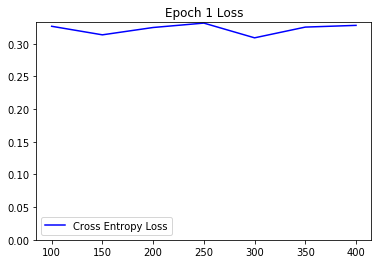


Training Epoch : 2/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.321
Validation Accuracy: 84.91%



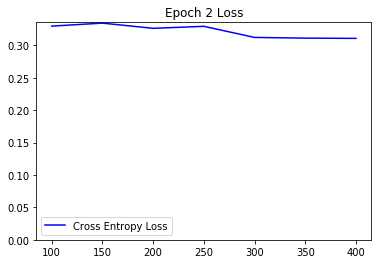


Training Epoch : 3/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.309
Validation Accuracy: 84.79%



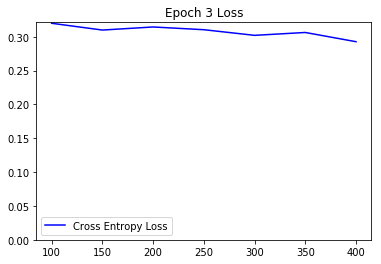


Training Epoch : 4/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.313
Validation Accuracy: 84.87%



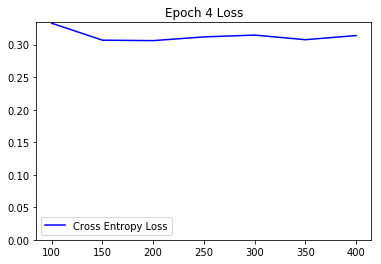


Training Epoch : 5/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.310
Validation Accuracy: 84.99%



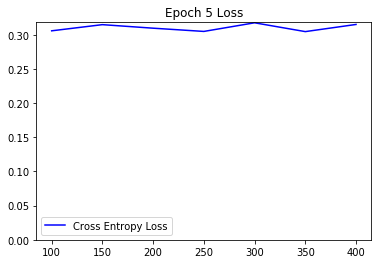


Training Epoch : 6/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.307
Validation Accuracy: 85.01%



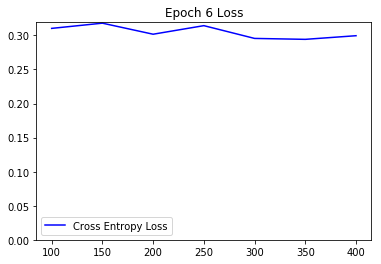


Training Epoch : 7/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.305
Validation Accuracy: 85.00%



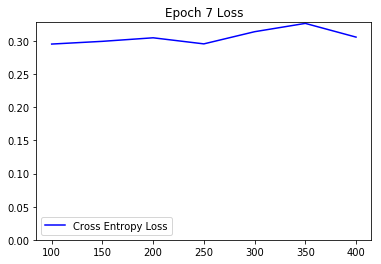


Training Epoch : 8/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.304
Validation Accuracy: 84.96%



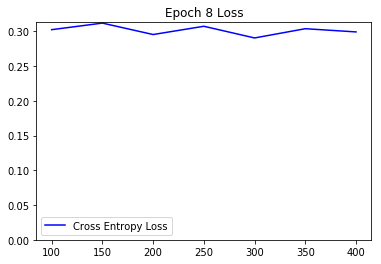


Training Epoch : 9/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.299
Validation Accuracy: 84.99%



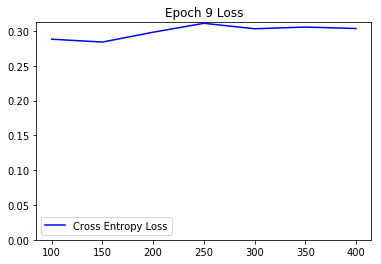


Training Epoch : 10/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.300
Validation Accuracy: 85.16%



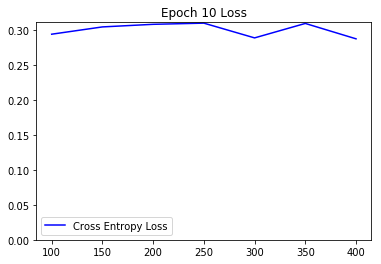


Training Epoch : 11/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.311
Validation Accuracy: 85.06%



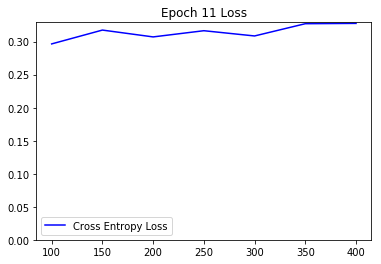


Training Epoch : 12/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.306
Validation Accuracy: 85.10%



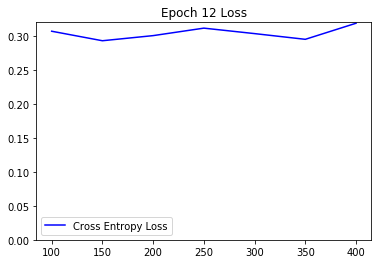


Training Epoch : 13/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.306
Validation Accuracy: 84.94%



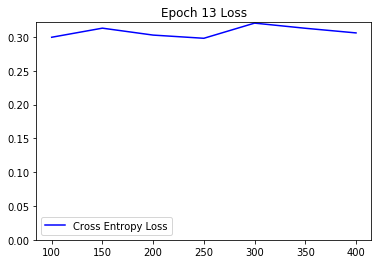


Training Epoch : 14/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.301
Validation Accuracy: 85.07%



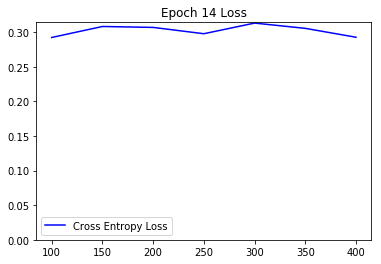


Training Epoch : 15/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.307
Validation Accuracy: 85.02%



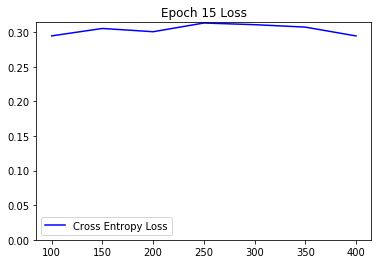


Training Epoch : 16/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.297
Validation Accuracy: 85.02%



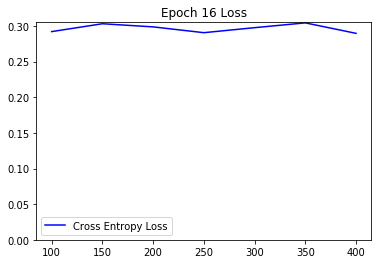


Training Epoch : 17/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.294
Validation Accuracy: 84.97%



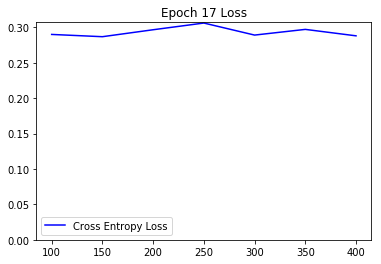


Training Epoch : 18/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.294
Validation Accuracy: 85.10%



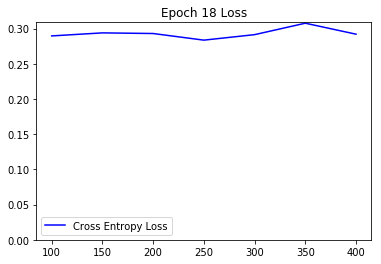


Training Epoch : 19/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.295
Validation Accuracy: 85.11%



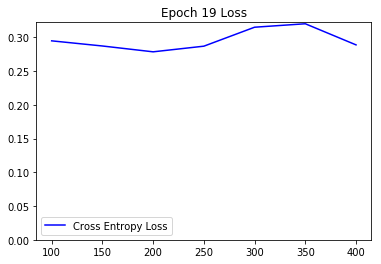


Training Epoch : 20/20
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed

Average Training Loss: 0.292
Validation Accuracy: 85.11%



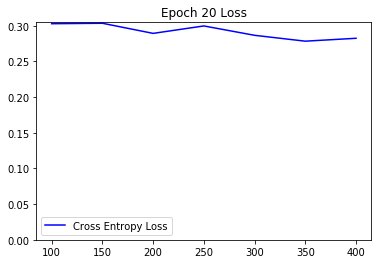


Best Validation Accuracy achieved by network: 85.16%



In [77]:
train(mode = 'lstm', hidden_dim = 100, epochs = 20, learning_rate = 5e-5)

In [78]:
test(mode = 'lstm', hidden_dim = 100)

INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Restoring parameters from logs_lstm_hl100/model_gs-11760

Model Restored

Test Accuracy: 84.59%


In [60]:
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', action = 'store_true')
    parser.add_argument('--test', action = 'store_true')
    parser.add_argument('--model', type = str)
    parser.add_argument('--hidden_unit', type = int)

    args = parser.parse_args()

    tr_val_split = 0.7
    batch_size = 100
    
    if args.train:
        print ("training mode")
        train(args.hidden_unit, 1e-3, 10, tr_val_split, batch_size, args.model)
        train(args.hidden_unit, 1e-4, 15, tr_val_split, batch_size, args.model)
        train(args.hidden_unit, 5e-5, 20, tr_val_split, batch_size, args.model)
    elif args.test:
        print ("test mode")
        test(args.model, args.hidden_unit)
    else:
        print ("default")
        train()

In [ ]:
if __name__ == '__main__':
    main()